# Text embeddings with Word2Vec, Sent2Vec and Doc2Vec

Many machine learning models require numeric features, thus text must be converted to numeric before they can be used in the model. Whilst a straight forward way is to one-hot encode the text, this results in extremely sparse datasets and an explosion in the number of columns. Text embedding is a smarter way to convert text to numeric features. In this notebook we will explore:

1. one hot encoding
2. Word2Vec
3. Sent2Vec
4. Doc2Vec

## 1. One hot encoding

To better understand why word embeddings are useful, we start by looking at how one hot encoding works. Suppose we have the sentence "The cat sat on the mat". There are 5 unique words in this sentence, thus after one hot encoding, it would look like the matrix below:

![one_hot_encode](one_hot_encode.PNG)

With just 5 words in our vocabularly, we have 5 new columns. Not only is this sparse, there are also no meaning between the numeric representation of words, as they are all just vectors with all 0s, except a 1 for the column mapped to the word. It would be better if we could compress and represent words as more densely filled numeric features, where the numeric word features could be compared against each other.

## 2. Word2Vec

### 2.1 Background

How can we map words to meaningful numeric vectors? What do we mean when we intuitively think of 2 words as similar? The subtleties of language can not be captured in any simple way, however word2vec takes two approaches which seems to work well in practice:

1. skip-gram approach - given a word, we try to predict its surrounding words
2. Continuous bag of words (CBOW) approach - given surrounding words, predict the word

In both cases, intuitively we are saying that the context of the word (i.e. words surrounding the given word) should be similar if two words are similar. The beauty of this approach is that we do need to provide any labels. Given any text, our labels are simply the surrounding words (or the word itself in case of CBOW).

Word2Vec is actually just a simple neural network.

![neural_net_word2vec](neural_net_word2vec.PNG)

As in the above diagram, we can see 3 layers:

1. First, we have a one-hot vector of all the unique words in the vocabulary. The length of the vector is the number of unique words.
2. In the middle, we have the hidden layer. The length of this vector will be the size of our embedded numeric representation of each feature.
3. Lastly, we have an output layer. This is the same length as the input layer with each node being a word.

In the case of skip-gram, the input is just a word. The label for this input will be the word before and after it (depending on window size). For example, for the sentence 'the cat sat on the mat', suppose we have window size 1. Given the input 'cat', there would be two targets: 'the' and 'sat'.

That is all there really is to it. We have an input and output. There is no activation function in the hidden layer, and the output layer is just a softmax layer. You may ask, 'ok, but where is the embedding for each word?'. For each input word, there is a connection to each node in the hidden layer. In the diagram above, each input node is connected to 300 nodes in the hidden layer. Thus, there will be 300 weights from each input node to the nodes in the hidden layer. These 300 weights are the embedding for the words! For each input node, we have a different set of 300 weights.

CBOW is very similar, with only the input and output effectively being swapped. This is clearly shown in the image below (with window size 2).

![cbow_vs_skipgram](cbow_vs_skipgram.PNG)

### 2.2 Python implementation of Word2vec

We will no have a go at implementing this in Python. We will use a dataset which contains text from different news articles. We will generate word embeddings for each word from this text, using gensim package.

Let us read in this data and have a look at a few rows.

In [1]:
import pandas as pd
from gensim.models import Word2Vec
from gensim.utils import tokenize
from gensim.matutils import cossim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

%matplotlib inline

In [2]:
# read in data
true = pd.read_csv("True.csv")
fake = pd.read_csv("Fake.csv")

# assign target for true or fake news
true['label'] = 'True'
fake['label'] = 'Fake'

df = pd.concat([true, fake], axis=0)
df.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",True
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",True
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",True
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",True
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",True


For each news, we have the title, the text in the article, as well as subject, date and label. For creating the word embeddings, we will just use the text column.

The gensim Word2Vec model requires the input to be a list of lists. Each item in the list is a 'document' and each document is also a list of tokenised words. We will iterate through each row, and use gensim's 'tokenize' function, which tokenises the article with some basic text cleaning. We also note that there have been no explicit removal of stopwords. Whilst there is debate on whether to include stop words or not (as word2vec may need them to determine context), gensim implementation actually samples from the context words, with downsampling of very frequent words.

In [3]:
# generate list of tokenized articles
sent = [list(tokenize(row, lowercase=True)) for row in df['text']]

In [25]:
# build doc2vec model
word2vec_model = Word2Vec(
    sent
    ,min_count=100
    ,size= 50
    ,workers=8
    ,window =3
    ,sg = 1
)

Once the Word2vec model has been built, we can extract the numeric representation of any word in the vocabulary. For example, the word vector for the word 'trump' is:

In [13]:
word2vec_model.wv['trump']

array([ 0.11586528, -0.24152464, -0.13837449,  0.13366874,  0.52861375,
        0.17899737, -0.06643107, -0.10873608, -0.72175145,  0.10611419,
        0.07636354,  0.46355247,  0.13806555,  0.6140098 ,  0.0579708 ,
       -0.46703532,  0.29567084,  0.07031407, -0.16187595,  0.05451605,
       -0.12358628, -0.11123726,  0.01242471,  0.1277387 , -0.40985894,
       -0.4520731 ,  0.43057147,  0.46789998,  0.42566517, -0.5791242 ,
        0.03951877, -0.16274752,  0.02388006,  0.6507051 , -0.09334566,
        0.31519005,  0.16595806, -0.17988834, -0.41716215,  0.28089333,
       -0.37880054, -0.34880206, -0.3642921 ,  0.23025498, -0.33501825,
        0.0582148 ,  0.08754615, -0.04026464,  0.33356762,  0.1960505 ],
      dtype=float32)

That is all that is required to build our word embeddings. We can iterate through and look at word embeddings for all out words.

In [14]:
word_vectors = [word2vec_model.wv[word] for word in word2vec_model.wv.vocab]
word_vec_df = pd.DataFrame.from_dict(dict(zip(word2vec_model.wv.vocab, word_vectors))).T

In [15]:
word_vec_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
washington,0.015501,-0.099894,-0.006939,0.426453,0.206974,0.143410,-0.330889,0.031119,0.368915,0.650614,...,0.109881,-0.249162,-0.268147,0.150026,0.329471,-0.196918,-0.137788,0.036685,-0.477783,-0.087658
reuters,0.138076,-0.288642,0.308406,0.371176,-0.497170,0.257485,-0.398729,0.348983,-0.063759,0.410156,...,-0.233612,-0.542278,-0.067449,0.456363,0.496109,-0.651099,-0.142468,-0.599793,-0.533077,-0.176125
the,-0.176469,0.091235,-0.029671,-0.012454,-0.182211,-0.284794,-0.237977,0.366916,0.288651,0.596655,...,0.222494,-0.115908,-0.277766,0.309373,-0.155691,-0.146297,-0.647301,0.063142,-0.188364,-0.157982
head,0.076832,0.162782,0.368623,0.247104,-0.057593,0.156370,-0.388140,0.441742,0.039877,0.323004,...,0.573209,-0.111241,-0.158779,0.035072,-0.392518,-0.431286,0.219586,-0.081029,-0.163571,0.344202
of,0.040882,0.301996,-0.248254,0.103709,-0.266932,-0.119806,0.024477,0.280175,0.436941,-0.058050,...,0.106579,-0.061924,-0.081664,0.506126,0.133045,-0.314716,-0.809488,-0.239885,-0.066187,-0.446268


### 2.3 Similarity using word embeddings

With these word embeddings, it is easy to compare similarity between different words. For example, to compare 'trump' and 'president', we would use the method below:

In [18]:
word2vec_model.wv.similarity('trump','president')

0.64442587

A question we may have is how is similarity defined? This will depend on the distance measure used. The 2 popular distance metrics are Euclidean and Cosine distance. These are defined below. There is no necessarily 'better' metric, however keep in mind that cosine only looks at the angle difference betwen two vectors and not the magnitude, whereas Euclidean is affected by the magnitude of the word vectors. This distinction is very important if embedding is dependent on count of words, however not as important in word2vec.

**Euclidean**

![euclidean](euclidean.PNG)

In [19]:
word2vec_model.wv.most_similar('trump')

[('donald', 0.9130532741546631),
 ('elect', 0.7318522930145264),
 ('potus', 0.7115991115570068),
 ('frontrunner', 0.675655722618103),
 ('j', 0.6698797941207886),
 ('jr', 0.6602543592453003),
 ('runner', 0.6548330783843994),
 ('president', 0.6444258093833923),
 ('pence', 0.6389528512954712),
 ('cruz', 0.6335755586624146)]

**Cosine**

![cosine](cosine.PNG)

In [20]:
word2vec_model.wv.most_similar_cosmul('trump')

[('donald', 0.9565257430076599),
 ('elect', 0.8659252524375916),
 ('potus', 0.8557987213134766),
 ('frontrunner', 0.8378270864486694),
 ('j', 0.8349390625953674),
 ('jr', 0.8301263451576233),
 ('runner', 0.8274157643318176),
 ('president', 0.8222121000289917),
 ('pence', 0.8194755911827087),
 ('cruz', 0.8167870044708252)]

### 2.4 Word2vec visualisation with T-SNE

T-SNE is a useful way to visualise similarity. This is done by taking a group of high-dimensional vocabulary word feature vectors, then compresses them down to 2-dimensional x, y coordinate pairs. This notebook will not cover more technical details regarding T-SNE, however it is important to note that is a way to visualise clusters in word embeddings, however there is a tendency for T-SNE to create clusters that may no exist that apparently, and also takes a long time to run.

Below, we will plot our word embeddings on a 2d plane using T-SNE. Note that we have retrained the Word2vec with min count = 1000 to ensure the code will not take too long, and more importantly to ensure that the plot does not become too cluttered.

In [21]:
def tsne_plot(model):
    "Creates a TSNE model and plots it"
    
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model.wv[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

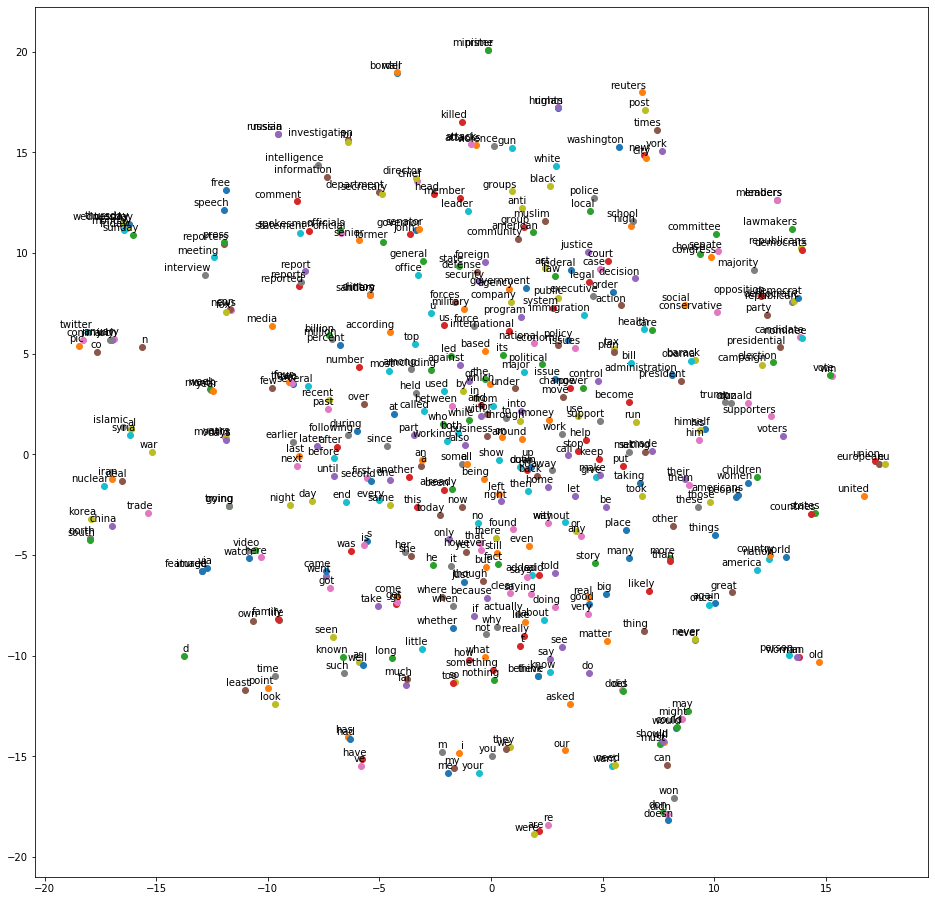

In [26]:
# create word2vec with fewer words for visualisation purposes
tsne_word2vec_model = Word2Vec(
    sent
    ,min_count=5000
    ,size= 50
    ,workers=8
    ,window =3
    ,sg = 1
)

tsne_plot(tsne_word2vec_model)

From the above plot, there are no obvious clusters, however we can roughly see a few groups:
- upper right related to presidential election (e.g. trump, president, americans, election, campaign
- upper middle related to defense and investigation (e.g. intelligence, invesitigation, police
- left related to media (e.g. twitter, interview, meeting. media)
- bottom contains many stop words, perhaps these should be removed

### 2.5 Averaging word embeddings

The advantage having word embeddings using Word2vec is that the numeric vectors have meaning, and therefore simply adding the vectors of two different words together still has meaning too. Given an article with many words, we can simply take the average of all the word vectors to get an embedding for the document. This method works quite well in practice, although there are other methods such as Doc2vec which directly create embeddings from each document.

Let us now embed each of the articles from the news in our original data, by averaging all the words in the document.

In [36]:
def document_vector(model, doc):
    '''determine average of all word embeddings in a list of words'''
    
    doc = [word for word in doc if word in model.wv.vocab]
    return np.mean(model.wv[doc], axis=0)

In [37]:
def has_vector_representation(model, doc):
    """check if at least one word of the document is in the word2vec dictionary"""
    
    return not all(word not in model.wv.vocab for word in doc)

In [41]:
embedded_doc = [
    document_vector(word2vec_model, tokenize(row, lowercase=True)) # average word embedding
    if has_vector_representation(word2vec_model, list(tokenize(row, lowercase=True))) # check if there is at least one word
    else np.zeros(50) # if no words, then return array of 0s
    for row in df['text'] # loop through each row
]

Below is the embedded articles for each news using average of the word embeddings. We can then use this as structured fields for whatever purpose, e.g. features for classifying news as true or fake.

In [47]:
embedded_doc_df = pd.DataFrame(embedded_doc)
embedded_doc_df.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.136118,0.153221,-0.047721,0.226328,-0.011082,-0.107774,-0.056428,0.257251,0.082070,0.212835,...,0.189435,-0.302526,0.164973,-0.097159,0.067709,0.054056,-0.093315,-0.330736,0.170959,-0.139562
1,0.056068,0.217898,-0.042916,0.228356,-0.107831,-0.045237,-0.056821,0.249532,0.152325,0.157537,...,0.249907,-0.284320,0.098917,-0.053061,0.051855,0.099148,-0.060416,-0.246738,0.130431,-0.200638
2,0.083453,0.279667,-0.040604,0.212508,-0.007921,-0.086179,-0.076668,0.259793,0.069163,0.314985,...,0.295078,-0.336408,0.119359,0.014671,0.055670,0.009414,-0.091027,-0.198803,0.181355,-0.159559
3,0.058556,0.266246,-0.093236,0.259640,0.063580,-0.058894,-0.113375,0.250336,0.104302,0.314002,...,0.332791,-0.371892,0.090249,-0.045715,0.048706,-0.009206,-0.075975,-0.205137,0.159797,-0.150549
4,0.079830,0.237863,-0.047601,0.165932,0.044356,-0.107397,-0.127992,0.197625,0.171604,0.164187,...,0.296399,-0.305779,0.121306,-0.040191,0.048386,0.018800,-0.088196,-0.343332,0.159868,-0.107563
